# Prism Data

In [1]:
import pandas as pd

In [2]:
consdf = pd.read_parquet('/uss/hdsi-prismdata/q2-ucsd-consDF.pqt')
consdf.head()

,prism_consumer_id,evaluation_date,credit_score,DQ_TARGET
0,0,2021-09-01,726.0,0.0
1,1,2021-07-01,626.0,0.0
2,2,2021-05-01,680.0,0.0
3,3,2021-03-01,734.0,0.0
4,4,2021-10-01,676.0,0.0


In [3]:
acctdf = pd.read_parquet('/uss/hdsi-prismdata/q2-ucsd-acctDF.pqt')
acctdf

,prism_consumer_id,prism_account_id,account_type,balance_date,balance
0,3023,0,SAVINGS,2021-08-31,90.57
1,3023,1,CHECKING,2021-08-31,225.95
2,4416,2,SAVINGS,2022-03-31,15157.17
3,4416,3,CHECKING,2022-03-31,66.42
4,4227,4,CHECKING,2021-07-31,7042.90
...,...,...,...,...,...
24461,11500,24461,CHECKING,2022-03-27,732.75
24462,11615,24462,SAVINGS,2022-03-30,5.00
24463,11615,24463,CHECKING,2022-03-30,1956.46
24464,12210,24464,CHECKING,2022-03-28,2701.51


In [4]:
trxndf = pd.read_parquet('/uss/hdsi-prismdata/q2-ucsd-trxnDF.pqt')
trxndf

,prism_consumer_id,prism_transaction_id,category,amount,credit_or_debit,posted_date
0,3023,0,4,0.05,CREDIT,2021-04-16
1,3023,1,12,481.56,CREDIT,2021-04-30
2,3023,2,4,0.05,CREDIT,2021-05-16
3,3023,3,4,0.07,CREDIT,2021-06-16
4,3023,4,4,0.06,CREDIT,2021-07-16
...,...,...,...,...,...,...
6407316,10533,6405304,31,4.96,DEBIT,2022-03-11
6407317,10533,6405305,12,63.48,DEBIT,2022-03-30
6407318,10533,6405306,12,53.99,DEBIT,2022-03-30
6407319,10533,6405307,12,175.98,DEBIT,2022-03-31


### Using Balance Date --> Recency of Balance

In [5]:
acctdf['balance_date'] = pd.to_datetime(acctdf['balance_date'])

In [6]:
df = acctdf.merge(consdf, on='prism_consumer_id')

In [7]:
df = df[df['balance_date'] <= df['evaluation_date']]

In [8]:
df = df.groupby(['prism_consumer_id', 'evaluation_date', 'account_type'])['balance_date'].max().reset_index()

In [9]:
df['recency'] = (df['evaluation_date'] - df['balance_date']).dt.days

In [10]:
df = df[df['account_type'].isin(df['account_type'].value_counts().iloc[:5].index)]

In [11]:
df.head()

,prism_consumer_id,evaluation_date,account_type,balance_date,recency
0,0,2021-09-01,CHECKING,2021-08-31,1
1,0,2021-09-01,SAVINGS,2021-08-31,1
2,1,2021-07-01,CHECKING,2021-06-30,1
3,1,2021-07-01,SAVINGS,2021-06-30,1
4,10,2022-02-01,CHECKING,2022-01-31,1


In [12]:
features = df.pivot(
    index=['prism_consumer_id', 'evaluation_date'],
    columns='account_type',
    values='recency'
)
features

,account_type,CHECKING,CREDIT CARD,LINE OF CREDIT,LOAN,SAVINGS
prism_consumer_id,evaluation_date,,,,,
0,2021-09-01,1.0,NaN,NaN,NaN,1.0
1,2021-07-01,1.0,NaN,NaN,NaN,1.0
10,2022-02-01,1.0,NaN,NaN,NaN,1.0
100,2021-12-01,215.0,NaN,NaN,NaN,NaN
10000,2022-03-18,4.0,4.0,NaN,NaN,4.0
...,...,...,...,...,...,...
9995,2023-03-02,0.0,NaN,NaN,NaN,NaN
9996,2023-10-11,0.0,NaN,NaN,NaN,NaN
9997,2023-05-25,0.0,NaN,NaN,NaN,NaN


In [13]:
final_df = consdf.merge(
    features,
    on=['prism_consumer_id', 'evaluation_date'],
    how='left'
)
final_df

,prism_consumer_id,evaluation_date,credit_score,DQ_TARGET,CHECKING,CREDIT CARD,LINE OF CREDIT,LOAN,SAVINGS
0,0,2021-09-01,726.0,0.0,1.0,NaN,NaN,NaN,1.0
1,1,2021-07-01,626.0,0.0,1.0,NaN,NaN,NaN,1.0
2,2,2021-05-01,680.0,0.0,1.0,NaN,NaN,NaN,1.0
3,3,2021-03-01,734.0,0.0,1.0,NaN,NaN,NaN,1.0
4,4,2021-10-01,676.0,0.0,1.0,NaN,NaN,NaN,274.0
...,...,...,...,...,...,...,...,...,...
14995,14995,2022-03-08,655.0,NaN,NaN,NaN,NaN,NaN,NaN
14996,14996,2022-01-15,625.0,NaN,0.0,NaN,NaN,NaN,0.0
14997,14997,2022-01-31,688.0,NaN,NaN,NaN,NaN,NaN,NaN
14998,14998,2022-03-08,722.0,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
final_df = final_df.dropna(subset='DQ_TARGET')

In [15]:
account_cols = final_df.columns[4:]

In [16]:
for col in account_cols:
    final_df[col] = final_df[col].fillna(final_df[col].max())
final_df

/tmp/ipykernel_620/2749024968.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df[col] = final_df[col].fillna(final_df[col].max())


,prism_consumer_id,evaluation_date,credit_score,DQ_TARGET,CHECKING,CREDIT CARD,LINE OF CREDIT,LOAN,SAVINGS
0,0,2021-09-01,726.0,0.0,1.0,22.0,11.0,9.0,1.0
1,1,2021-07-01,626.0,0.0,1.0,22.0,11.0,9.0,1.0
2,2,2021-05-01,680.0,0.0,1.0,22.0,11.0,9.0,1.0
3,3,2021-03-01,734.0,0.0,1.0,22.0,11.0,9.0,1.0
4,4,2021-10-01,676.0,0.0,1.0,22.0,11.0,9.0,274.0
...,...,...,...,...,...,...,...,...,...
13995,13995,2022-01-22,802.0,0.0,0.0,0.0,11.0,9.0,0.0
13996,13996,2022-02-01,652.0,0.0,0.0,0.0,11.0,9.0,0.0
13997,13997,2021-12-24,765.0,0.0,9.0,22.0,11.0,9.0,9.0
13998,13998,2022-01-30,685.0,0.0,0.0,0.0,11.0,0.0,0.0


### Evaluation & Visualization

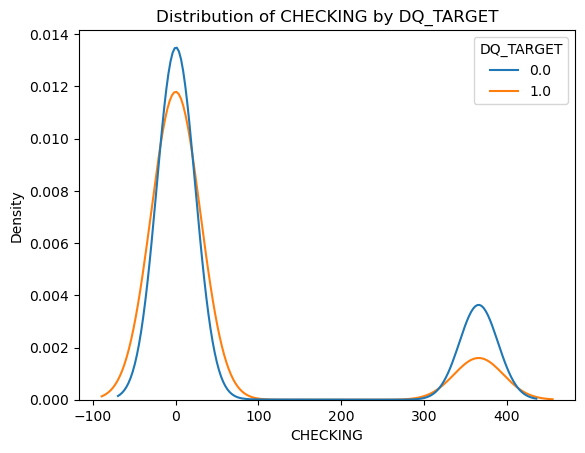

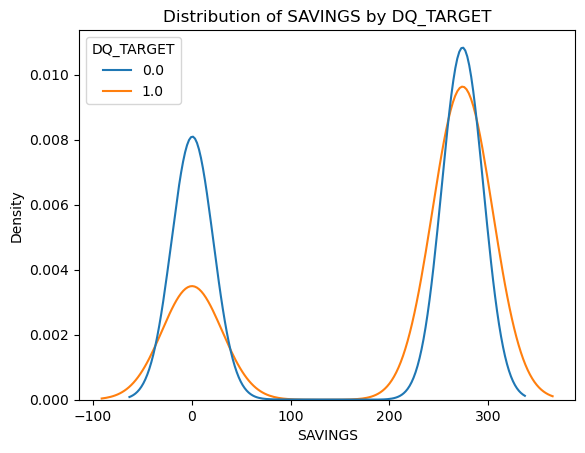

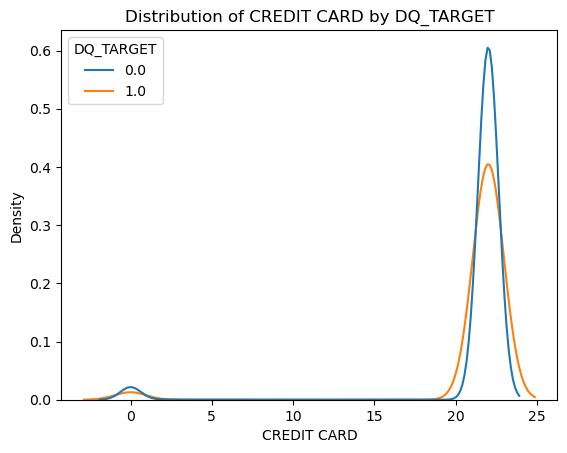

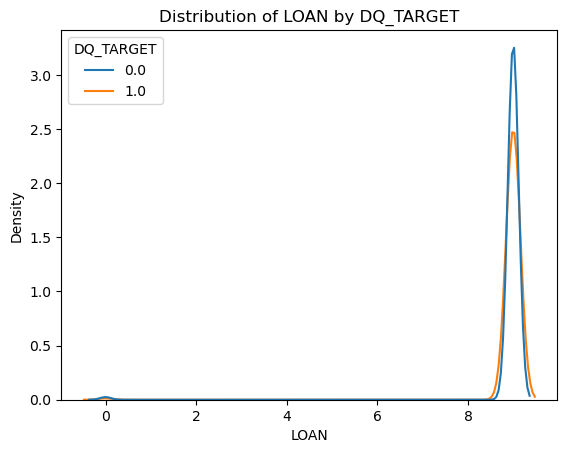

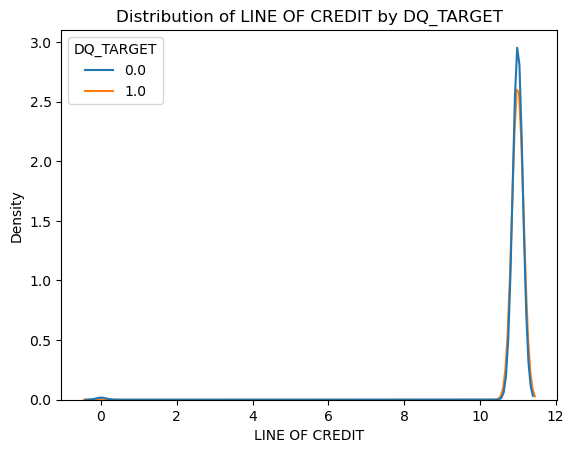

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

account_cols = ['CHECKING', 'SAVINGS', 'CREDIT CARD', 'LOAN', 'LINE OF CREDIT']

for col in account_cols:
    sns.kdeplot(data=final_df, x=col, hue='DQ_TARGET', common_norm=False)
    plt.title(f'Distribution of {col} by DQ_TARGET')
    plt.show()

In [18]:
from scipy.stats import pointbiserialr

for col in account_cols:
    corr, pval = pointbiserialr(final_df['DQ_TARGET'].fillna(0), final_df[col])
    print(f'{col}: correlation={corr:.3f}, p-value={pval:.3g}')

CHECKING: correlation=-0.064, p-value=1.6e-12
SAVINGS: correlation=0.091, p-value=1.92e-23
CREDIT CARD: correlation=0.008, p-value=0.403
LOAN: correlation=0.008, p-value=0.375
LINE OF CREDIT: correlation=0.012, p-value=0.204


* Significant correlation (p-value < 0.05) between recency of last balance for each of the top 5 account types and DQ_TARGET for both checking and savings
* Checking:
  * For both DQ_TARGET of 0 and 1, higher probability of last balance being in less days (more recent) for checking, which generally deals with day-to-day transactions and spending --> makes sense for balances to be more frequent with shorter periods of time in between
  * More variance for DQ_TARGET = 1 in the shorter amount of time cluster --> makes sense since DQ_TARGET = 1 means they are more unreliable
* Savings:
  * For both DQ_TARGET of 0 and 1, higher probability of last balance being in more days (long-term, better for future goals and emergencies)
  * Greater variance for both distributions for DQ_TARGET = 1 (more unreliable)

### Evaluation - ROC & AUC

In [19]:
# imports
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

In [34]:
cats = ['CHECKING', 'CREDIT CARD', 'LINE OF CREDIT', 'LOAN', 'SAVINGS']

In [39]:
for col in cats:
    y = final_df['DQ_TARGET']
    print(f"{col}: {round(roc_auc_score(y,final_df[f'{col}']),3)}")

CHECKING: 0.356
CREDIT CARD: 0.503
LINE OF CREDIT: 0.502
LOAN: 0.501
SAVINGS: 0.56


In [41]:
y = final_df['DQ_TARGET']
x_savings = final_df['SAVINGS']
auc_savings = roc_auc_score(y, x_savings)

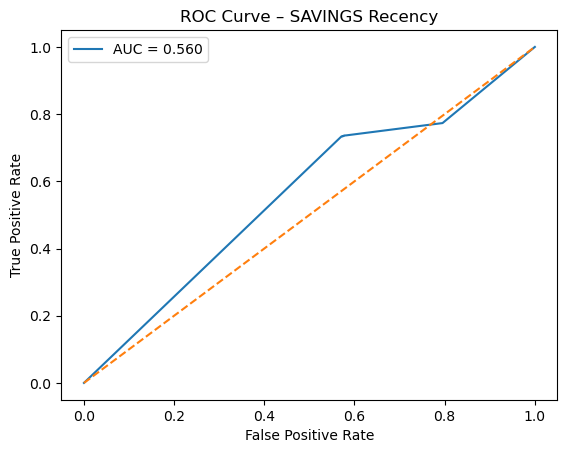

In [43]:
fpr, tpr, thresholds = roc_curve(y, x_savings)

plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {auc_savings:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – SAVINGS Recency')
plt.legend()
plt.show()

In [44]:
y = final_df['DQ_TARGET']
x_credit_card = final_df['CREDIT CARD']
auc_credit_card = roc_auc_score(y, x_credit_card)

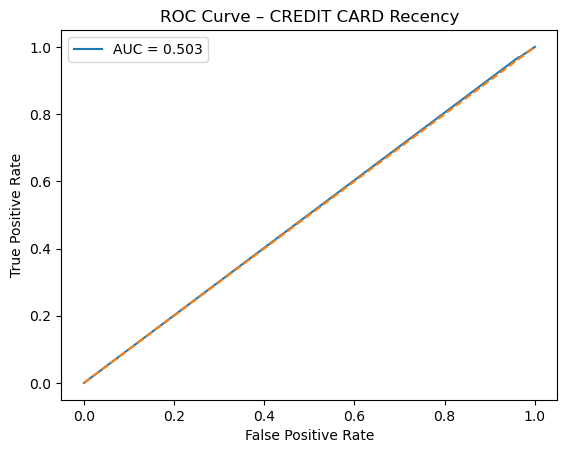

In [45]:
fpr, tpr, thresholds = roc_curve(y, x_credit_card)

plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {auc_credit_card:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – CREDIT CARD Recency')
plt.legend()
plt.show()

### Precision & Recall

In [46]:
from sklearn.metrics import precision_score, recall_score

In [51]:
for col in cats:
    fpr, tpr, thresholds = roc_curve(y, final_df[col])
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    y_pred = (final_df[col] >= optimal_threshold).astype(int)
    
    precision = precision_score(y, y_pred, zero_division=0)
    recall = recall_score(y, y_pred)
    print(f"{col}: Precision={precision:.3f}, Recall={recall:.3f}")

CHECKING: Precision=0.000, Recall=0.000
CREDIT CARD: Precision=0.084, Recall=0.969
LINE OF CREDIT: Precision=0.084, Recall=0.997
LOAN: Precision=0.084, Recall=0.995
SAVINGS: Precision=0.105, Recall=0.734
